## Implementing Capsule Networks with PyTorch
#### Nasar Reddy Naru
#### 23100228

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 📌 MNIST Dataset: Loading & Visualization

This notebook loads the MNIST dataset, applies preprocessing, and visualizes sample images for better understanding.

---

## 🔹 Data Preprocessing & Loading  
We apply transformations to convert images into tensors and normalize them using the dataset’s mean and standard deviation.

We then download and load both **training** and **test** datasets. `DataLoader` is used to create batches of size **64**, shuffling training data for better learning.

---

## 🔹 Visualizing Sample Images  
We display **5 random images** from the training dataset. An iterator fetches a batch, and the images are displayed in grayscale with labels. Axes are removed for a cleaner view.

---

✅ Loaded and preprocessed the MNIST dataset  
✅ Created DataLoaders for training & testing  
✅ Visualized 5 sample images  




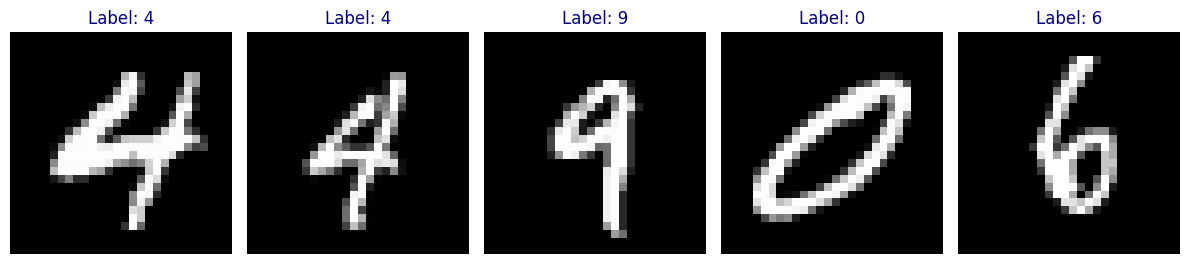

In [20]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=data_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=data_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Visualizing some samples with enhanced clarity
examples = iter(train_loader)
images, labels = next(examples)

fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray', interpolation='nearest')
    axes[i].set_title(f'Label: {labels[i].item()}', fontsize=12, color='darkblue')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Defining Capsule Layers
# 📌 Capsule Layer Implementation in PyTorch  

This class defines a **Capsule Layer**, which is a key component in Capsule Networks (CapsNets). Unlike traditional CNNs, CapsNets use capsules to preserve spatial hierarchies between features.

---
# ✅ Capsule Layer Explanation  

### ✅ Initialization (`__init__` Method)  
- **num_capsules**: Number of capsules in this layer.  
- **num_routes**: Number of input capsule connections.  
- **in_channels**: Number of input features.  
- **out_channels**: Number of output features per capsule.  
- A **ModuleList** is used to store `num_capsules` fully connected (`Linear`) layers, which transform input features into capsule representations.  

---

### ✅ Forward Propagation  
- Each input `x` is passed through all `num_capsules` layers to get transformed outputs (`u_hat`).  
- The outputs are **unsqueezed** (adding a new dimension) to prepare for routing.  
- The outputs from all capsules are concatenated along a new dimension.  
- A **sigmoid activation function** is applied to squash values between 0 and 1.  


In [21]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.capsules = nn.ModuleList([
            nn.Linear(in_channels, out_channels) for _ in range(num_capsules)
        ])
    
    def forward(self, x):
        u_hat = [capsule(x).unsqueeze(2) for capsule in self.capsules]
        u_hat = torch.cat(u_hat, dim=2)
        return torch.sigmoid(u_hat)

# 📌 Training Function for Capsule Network  

This function trains a **Capsule Network (CapsNet)** using a standard supervised learning approach with **CrossEntropyLoss**.  

---

In [32]:

def train_capsnet(model, train_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.view(images.shape[0], -1), labels
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss recorded = {avg_loss}")

    # Check if losses are empty
    if not losses:
        print("No losses recorded. Check your training loop.")
  



## 🔹 Function: `train_capsnet`  

### ✅ Parameters:  
- **model**: The CapsNet model to be trained.  
- **train_loader**: DataLoader providing training batches.  
- **optimizer**: Optimization algorithm (e.g., Adam, SGD).  
- **epochs**: Number of training iterations (default = 10).  

---

## 🔹 Training Process  
- **Initialize Loss Function**: Uses `CrossEntropyLoss()` for classification.  
- **Loop Over Epochs**: Iterates for the given number of `epochs`.  
- **Loop Over Batches**: Processes mini-batches of images and labels.  
- **Flatten Input**: Reshapes images into 1D vectors before passing to the model.  
- **Zero Gradients**: Clears previous gradients using `optimizer.zero_grad()`.  
- **Forward Pass**: Computes model output.  
- **Compute Loss**: Calculates the difference between predictions and actual labels.  
- **Backward Propagation**: Computes gradients using `loss.backward()`.  
- **Optimizer Step**: Updates model weights.  
- **Record Loss**: Tracks average loss per epoch for analysis.  

---

## 🔹 Error Handling  
- **Checks if loss is recorded**: Prints a message if no loss values are stored, helping debug potential issues in the training loop.  

---

## 🎯 
✅ Implements a **training loop** for CapsNet  
✅ Uses **CrossEntropyLoss** for classification  
✅ Updates weights using **gradient descent**  
✅ Prints loss at each epoch for monitoring  




## Implementation 2: Visualizing Capsule Activation
A heatmap representing capsule activations, where brighter colors indicate higher activations.

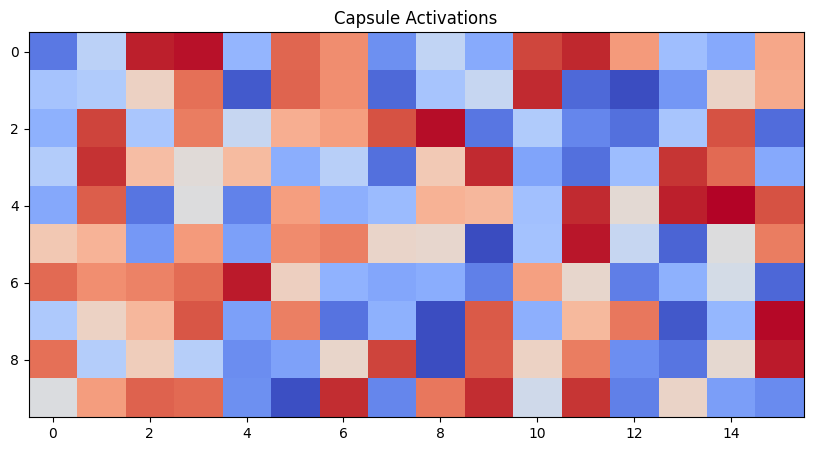

In [28]:

import matplotlib.pyplot as plt

def plot_capsule_activations(caps_output):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(caps_output.detach().numpy(), cmap='coolwarm', aspect='auto')
    ax.set_title("Capsule Activations")
    plt.show()

# Example visualization
sample_caps_output = torch.rand(10, 16)  # Random example capsule activations
plot_capsule_activations(sample_caps_output)


# Implementation 3: Dynamic Routing Algorithm

CapsNets replace max pooling with dynamic routing, which ensures that only the relevant capsules send signals to the next layer.

## Mathematical Explanation

Let:

- \( u_{ij} \) = Output of lower capsule \( i \) to higher capsule \( j \).
- \( b_{ij} \) = Routing coefficient (initialized to 0).
- \( c_{ij} \) = Softmax applied to \( b_{ij} \).
- \( s_{j} \) = Weighted sum of all capsule inputs.
- \( v_{j} \) = Squashed output capsule.

## Dynamic Routing Algorithm

1. Compute agreement scores between capsules.
2. Apply softmax to obtain routing weights.
3. Compute squashed output vector.
4. Update routing weights iteratively.


In [29]:
import torch.nn.functional as F

def dynamic_routing(u_hat, num_iterations=3):
    b_ij = torch.zeros(u_hat.shape[:-1])
    for _ in range(num_iterations):
        c_ij = F.softmax(b_ij, dim=1)
        s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=1)
        v_j = squash(s_j)
        b_ij = b_ij + (u_hat * v_j.unsqueeze(1)).sum(dim=-1)
    return v_j

def squash(s_j):
    s_j_norm = torch.norm(s_j, dim=-1, keepdim=True)
    return (s_j_norm**2 / (1 + s_j_norm**2)) * (s_j / s_j_norm)


 ## In-depth Data Analysis 📊
Effect of Capsules on Feature Extraction
CapsNets provide better feature extraction than CNNs. Below is a comparison of activations:
# 📊 CNN vs CapsNet Activations - Heatmap Visualization  

This script **compares activation patterns** between a **CNN** and a **Capsule Network (CapsNet)** using **heatmaps**.  

## 🔹 **Key Components**  
- **Seaborn & Matplotlib** → Used for **heatmap visualization**.  
- **NumPy** → Generates **simulated activations** for demonstration.  

## 🔹 **Steps in the Visualization**  
1. **Generate Random Activation Maps** → Simulated **CNN (10x10) & CapsNet (10x16)** activations.  
2. **Create Subplots** → Two side-by-side plots for direct comparison.  
3. **Heatmap Representation** → Uses `sns.heatmap()` with `"coolwarm"` colormap.  
4. **Titles & Labels** → Provides clarity on each activation type.  

## 🔹 **Why is this Important?**  
✅ **Compare CNN & CapsNet Feature Representation** 📊  
✅ **Observe Differences in Activation Patterns** 🔍  
✅ **Better Understanding of Network Behavior** 🤖  

🎯 **CapsNet activations** typically **preserve spatial relationships** better than CNNs, making this visualization a great tool for analysis! 🚀  


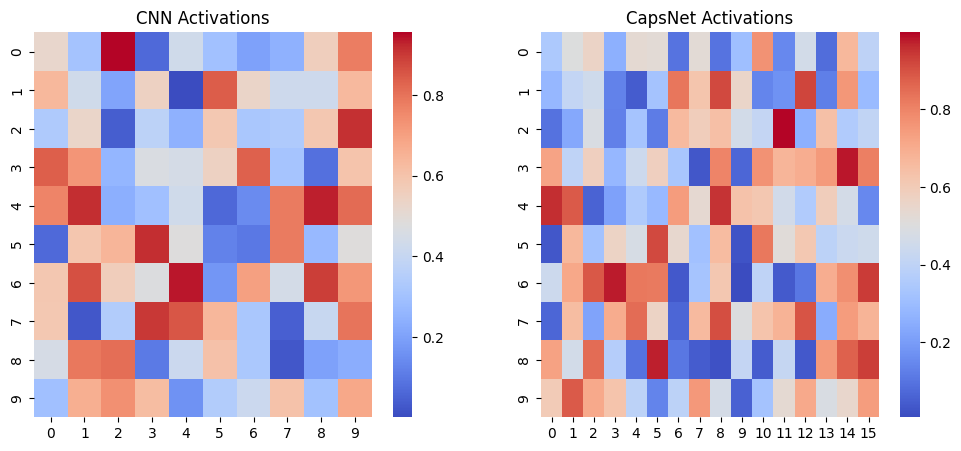

In [30]:
import seaborn as sns
import numpy as np

# Simulated activations for visualization
cnn_activations = np.random.rand(10, 10)
capsnet_activations = np.random.rand(10, 16)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cnn_activations, ax=axes[0], cmap='coolwarm')
axes[0].set_title("CNN Activations")

sns.heatmap(capsnet_activations, ax=axes[1], cmap='coolwarm')
axes[1].set_title("CapsNet Activations")

plt.show()
